In [17]:

import csv
import os
import random
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm

# Re-Writing dataset

In [18]:
# Function used to count number of samples in each class in each set
def count_files_in_subfolders(parent_folder):
    subfolders = ['wet_asphalt_smooth', 'wet_concrete_smooth', 'wet_gravel']
    wet_asphalt_smooth = 0
    wet_concrete_smooth = 0
    wet_gravel = 0
    for subfolder in subfolders:
        path = os.path.join(parent_folder, subfolder)
        if os.path.exists(path):
            count = sum([len(files) for r, d, files in os.walk(path)])
            print(f"The {subfolder} folder contains {count} files.")
            
            if subfolder == 'wet_asphalt_smooth':
                wet_asphalt_smooth += count
            if subfolder == 'wet_concrete_smooth':
                wet_concrete_smooth += count
            if subfolder == 'wet_gravel':
                wet_gravel += count
        else:
            print(f"The {subfolder} folder does not exist in the specified path.")
    return [wet_asphalt_smooth, wet_concrete_smooth, wet_gravel]

# Prints out the number of files in each folder and accumulates them
print('Train')
train_total = count_files_in_subfolders("Group_9_wet_smooth/Train")

print('Test')
test_total = count_files_in_subfolders("Group_9_wet_smooth/Test")

print('Validation')
valid_total = count_files_in_subfolders("Group_9_wet_smooth/Valid")

grand_total = np.array(train_total) + np.array(test_total) + np.array(valid_total)

print(f'Total wet_asphalt_smooth: {grand_total[0]}')
print(f'Total wet_concrete_smooth: {grand_total[1]}')
print(f'Total wet_gravel: {grand_total[2]}')

# Calculate the ideal based on the minority class
ideal_train = round(np.min(grand_total) * 0.8,0)
ideal_test = round(np.min(grand_total) * 0.1,0)
ideal_valid = round(np.min(grand_total) * 0.1,0)

print(f"\nIdeal split for 80% train, 10% test, 10% validation:")
print(f"Train: {ideal_train} files")
print(f"Test: {ideal_test} files")
print(f"Validation: {ideal_valid} files")


Train
The wet_asphalt_smooth folder contains 79404 files.
The wet_concrete_smooth folder contains 66955 files.
The wet_gravel folder contains 36515 files.
Test
The wet_asphalt_smooth folder contains 79 files.
The wet_concrete_smooth folder contains 160 files.
The wet_gravel folder contains 2351 files.
Validation
The wet_asphalt_smooth folder contains 821 files.
The wet_concrete_smooth folder contains 821 files.
The wet_gravel folder contains 821 files.
Total wet_asphalt_smooth: 80304
Total wet_concrete_smooth: 67936
Total wet_gravel: 39687

Ideal split for 80% train, 10% test, 10% validation:
Train: 31750.0 files
Test: 3969.0 files
Validation: 3969.0 files


In [19]:
# Reads a file from old path and writes to new path
def read_and_write_img(old_path,new_path):
    try:
        img = cv2.imread(old_path)
        img = cv2.resize(img, (96, 64), interpolation=cv2.INTER_CUBIC)
        cv2.imwrite(new_path, img)
    except:
        print(f'failed on {old_path}')

# Takes in old and new dataset folders, the names of the classes and the number of files to be written to the test and validation sets
def balance_dataset(old_dataset_folder, new_dataset_folder, classes, test_valid_count):
    sets = ['Train', 'Test', 'Valid']
    file_lists = {}

    # Load and shuffle file lists, shuffling done to ensure excess files taken from old training sets are random.
    for set_name in sets:
        for class_name in classes:
            old_path = os.path.join(old_dataset_folder, set_name, class_name)
            files = os.listdir(old_path)
            random.shuffle(files)
            file_lists[(set_name, class_name)] = files

    # Process Validation and Test sets
    for set_name in ['Valid', 'Test']:
        print(set_name) # For debugging purposes
        for class_name in classes:
            print(class_name)
            new_path = os.path.join(new_dataset_folder, set_name, class_name)
            os.makedirs(new_path, exist_ok=True)

            # While there are not enough files in the new test or valid folder for a given class
            # This will try take a file from the old test/valid folder and if it has run out it will 
            # instead take the extra it needs from the training class
            while len(os.listdir(new_path)) < test_valid_count:
                if len(file_lists[(set_name, class_name)]) > 0:
                    file_name = file_lists[(set_name, class_name)].pop(0)
                    old_img_path = os.path.join(old_dataset_folder, set_name, class_name, file_name)
                    new_img_path = os.path.join(new_path, file_name)

                    read_and_write_img(old_img_path,new_img_path)
                elif len(file_lists[('Train', class_name)]) > 0:
                    file_name = file_lists[('Train', class_name)].pop(0)
                    old_img_path = os.path.join(old_dataset_folder, 'Train', class_name, file_name)
                    new_img_path = os.path.join(new_path, file_name)

                    read_and_write_img(old_img_path,new_img_path)
                else:
                    break

    print('Train')
    # Process Train set
    for class_name in classes:
        print(class_name)
        new_path = os.path.join(new_dataset_folder, 'Train', class_name)
        os.makedirs(new_path, exist_ok=True)

        while file_lists[('Train', class_name)]:
            file_name = file_lists[('Train', class_name)].pop(0)
            old_img_path = os.path.join(old_dataset_folder, 'Train', class_name, file_name)
            new_img_path = os.path.join(new_path, file_name)
            read_and_write_img(old_img_path,new_img_path)

old_dataset_folder = "Group_9_wet_smooth"
new_dataset_folder = "New_dataset"
classes = ['wet_asphalt_smooth', 'wet_concrete_smooth', 'wet_gravel']
test_valid_count = 3969

# Commented out as this has already been completed.
# balance_dataset(old_dataset_folder, new_dataset_folder, classes, test_valid_count)


# Data Loading 

In [20]:
# Creates a dataset given img directories
class ImageDataset(Dataset):
    def __init__(self, img_dirs, transform=None):
        self.img_dirs = img_dirs
        self.transform = transform
        self.images = []
        self.labels = []
        # Utilises the enumerate as the label
        for i, img_dir in enumerate(img_dirs):
            for img_name in os.listdir(img_dir):
                img_path = os.path.join(img_dir, img_name)
                self.images.append(img_path)
                self.labels.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = cv2.imread(self.images[idx])
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Conversion to tensor also normalises images between 0 and 1
inception_transform = transforms.Compose([
    transforms.ToTensor(),
])
    
# Creates train, validation and test loaders
def create_data_loaders(train_dirs, valid_dirs, test_dirs, batch_size, train_samples, transform=inception_transform):
 

    # Creates datasets
    train_datasets = ImageDataset(train_dirs, transform=transform)
    valid_datasets = ImageDataset(valid_dirs, transform=transform)
    test_datasets = ImageDataset(test_dirs, transform=transform)


    

    # Given the massive imbalance in the samples in each class a WeightedRandomSampler is used to allow the model to learn properly
    # Weights len is of len(num_samples) to give each a weight.
    weights_len = len(os.listdir(train_dirs[0])) + len(os.listdir(train_dirs[1])) + len(os.listdir(train_dirs[2]))
    sampler_weights = np.zeros(weights_len)

    # Pytorch takes all the values in a weighted random sampler and normalises them between 0 and 1 so the sampler_weights array does not have to sum to 1
    # All of the samples for each class are given a weight of 1 / Class_num_samples which leads to roughly equal numbers of each class being returned each epoch
    sampler_weights[:len(os.listdir(train_dirs[0]))] = 1/len(os.listdir(train_dirs[0]))
    sampler_weights[len(os.listdir(train_dirs[0])):-len(os.listdir(train_dirs[2]))] = 1/len(os.listdir(train_dirs[1]))
    sampler_weights[-len(os.listdir(train_dirs[2])):] = 1/len(os.listdir(train_dirs[2]))

    # sampler is created with the weights, a configurable number of samples per epoch and replacement enabled.
    sampler = WeightedRandomSampler(weights=sampler_weights, num_samples=train_samples, replacement=True)
    
    # Loaders are created from datasets with configurable batch_size
    train_loader = DataLoader(train_datasets, batch_size=batch_size, sampler=sampler)
    valid_loader = DataLoader(valid_datasets, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_datasets, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader

# Model Training

In [31]:
def train_model(model, train_loader, valid_loader, test_loader, epochs, optimizer, criterion, 
                title, train_samples, learning_rate, batch_size, patience=5):
    
    # All of the variables needed to train a model are passed to the train model function to allow it to be reused.

    # GPU utilised for training.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    

    # Timestamp taken for saving of models and stats of each training run
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    train_loss_list, train_acc_list , valid_loss_list, valid_acc_list , test_loss_list , test_acc_list  = [],[],[],[],[],[]     
    best_valid_loss = float('inf')
    patience_counter = 0

    # Makes folder for logging
    os.makedirs(f'models/{timestamp}', exist_ok=True)
    with open(f'models/{timestamp}/{title}.txt', 'w') as f:
        f.write(f'Learning Rate: {learning_rate}\n')
        f.write(f'Epochs: {epochs}\n')
        f.write(f'Train Samples: {train_samples}\n')
        f.write(f'Batch Size: {batch_size}\n')
        
    # Opens csv to log Loss and Accuracy
    with open(f'models/{timestamp}/training_stats.csv', mode='w', newline='') as csvfile:
        fieldnames = ['Epoch', 'Train Loss', 'Train Acc', 'Valid Loss', 'Valid Acc', 'Test Loss', 'Test Acc']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for epoch in range(epochs):
            train_loss = 0.0
            train_correct = 0
            model.train()
            # Runs through all values in trainloader learns and accumulates loss and accuracy
            for i, data in enumerate(tqdm(train_loader, desc='Batches',leave=False)):
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                labels = labels.to(torch.long)  
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                train_correct += (predicted == labels).sum().item()

            # Accumulates loss and accuracy of validation set
            valid_loss = 0.0
            valid_correct = 0
            model.eval()
            with torch.no_grad():
                for i, data in enumerate(tqdm(valid_loader, desc='Batches',leave=False)):
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    labels = labels.to(torch.long)  
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    valid_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    valid_correct += (predicted == labels).sum().item()

            # Accumulates loss and accuracy of test set
            test_loss = 0.0
            test_correct = 0
            with torch.no_grad():
                for i, data in enumerate(tqdm(test_loader, desc='Batches',leave=False)):
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    labels = labels.to(torch.long)  
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    test_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    test_correct += (predicted == labels).sum().item()

            # Gets average loss and average accuracy for train, validation and test
            # Train_samples = configurable length of the trainloader
            train_loss /= train_samples;                train_acc = train_correct / train_samples
            valid_loss /= len(valid_loader.dataset);    valid_acc = valid_correct / len(valid_loader.dataset)
            test_loss /= len(test_loader.dataset);      test_acc = test_correct / len(test_loader.dataset)

            train_loss_list.append(train_loss),train_acc_list.append(train_acc),valid_loss_list.append(valid_loss),
            valid_acc_list.append(valid_acc),test_loss_list.append(test_loss),test_acc_list.append(test_acc)

            print(f'Epoch: {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

            writer.writerow({'Epoch': epoch,
                             'Train Loss': train_loss,
                             'Train Acc': train_acc,
                             'Valid Loss': valid_loss,
                             'Valid Acc': valid_acc,
                             'Test Loss': test_loss,
                             'Test Acc': test_acc,})
            
            # Updates best loss achieved, resets patience counter and saves the model
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                patience_counter = 0
                torch.save(model.state_dict(), f'models/{timestamp}/{epoch}.chkpt')
            # else increments the patience counter and if it has reached a limit stops the training.
            # Patience counter is implemented so if the model is overfitting resources will not be wasted.
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print('Early stopping')
                    break
        
        # Plots the models loass and accuracy.
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_list, label='Train')
        plt.plot(valid_loss_list, label='Valid')
        plt.plot(test_loss_list, label='Test')
        plt.title(f'{title} - Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_acc_list, label='Train')
        plt.plot(valid_acc_list, label='Valid')
        plt.plot(test_acc_list, label='Test')
        plt.title(f'{title} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    # Move model and tensors off the GPU
    model.cpu()
    torch.cuda.empty_cache()  # Clear GPU cache


# Defining Datasets and Running code

In [22]:
train_dirs = ["New_dataset/Train/wet_asphalt_smooth", "New_dataset/Train/wet_concrete_smooth", "New_dataset/Train/wet_gravel"]
valid_dirs = ["New_dataset/Valid/wet_asphalt_smooth", "New_dataset/Valid/wet_concrete_smooth", "New_dataset/Valid/wet_gravel"]
test_dirs = ["New_dataset/Test/wet_asphalt_smooth", "New_dataset/Test/wet_concrete_smooth", "New_dataset/Test/wet_gravel"]

### Shallow CNN

Batches: 100%|██████████| 313/313 [00:17<00:00, 17.80it/s]


Epoch: 0/50, Train Loss: 1.0775, Train Acc: 0.4179, Valid Loss: 0.9443, Valid Acc: 0.5849, Test Loss: 0.9451, Test Acc: 0.5814


Batches: 100%|██████████| 313/313 [00:23<00:00, 13.33it/s]


Epoch: 1/50, Train Loss: 0.8201, Train Acc: 0.6048, Valid Loss: 0.7891, Valid Acc: 0.6070, Test Loss: 0.7837, Test Acc: 0.6117


Batches: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch: 2/50, Train Loss: 0.7848, Train Acc: 0.6161, Valid Loss: 0.7798, Valid Acc: 0.6190, Test Loss: 0.7660, Test Acc: 0.6250


Batches: 100%|██████████| 313/313 [00:19<00:00, 16.47it/s]


Epoch: 3/50, Train Loss: 0.7684, Train Acc: 0.6300, Valid Loss: 0.7663, Valid Acc: 0.6246, Test Loss: 0.7548, Test Acc: 0.6315


Batches: 100%|██████████| 313/313 [00:17<00:00, 17.74it/s]


Epoch: 4/50, Train Loss: 0.7587, Train Acc: 0.6353, Valid Loss: 0.7565, Valid Acc: 0.6321, Test Loss: 0.7451, Test Acc: 0.6395


Batches: 100%|██████████| 313/313 [00:16<00:00, 18.52it/s]


Epoch: 5/50, Train Loss: 0.7529, Train Acc: 0.6421, Valid Loss: 0.7457, Valid Acc: 0.6296, Test Loss: 0.7457, Test Acc: 0.6335


Batches: 100%|██████████| 313/313 [00:15<00:00, 19.79it/s]


Epoch: 6/50, Train Loss: 0.7469, Train Acc: 0.6508, Valid Loss: 0.7259, Valid Acc: 0.6440, Test Loss: 0.7215, Test Acc: 0.6511


Batches: 100%|██████████| 313/313 [00:14<00:00, 20.96it/s]


Epoch: 7/50, Train Loss: 0.7248, Train Acc: 0.6650, Valid Loss: 0.7014, Valid Acc: 0.6634, Test Loss: 0.6928, Test Acc: 0.6772


Batches: 100%|██████████| 313/313 [00:13<00:00, 22.45it/s]


Epoch: 8/50, Train Loss: 0.6904, Train Acc: 0.6891, Valid Loss: 0.6643, Valid Acc: 0.6927, Test Loss: 0.6531, Test Acc: 0.7061


Batches: 100%|██████████| 313/313 [00:13<00:00, 23.53it/s]


Epoch: 9/50, Train Loss: 0.6542, Train Acc: 0.7104, Valid Loss: 0.6334, Valid Acc: 0.7120, Test Loss: 0.6201, Test Acc: 0.7282


Batches: 100%|██████████| 313/313 [00:13<00:00, 23.79it/s]


Epoch: 10/50, Train Loss: 0.6349, Train Acc: 0.7304, Valid Loss: 0.6205, Valid Acc: 0.7169, Test Loss: 0.6073, Test Acc: 0.7347


Batches: 100%|██████████| 313/313 [00:13<00:00, 23.02it/s]


Epoch: 11/50, Train Loss: 0.6075, Train Acc: 0.7417, Valid Loss: 0.6045, Valid Acc: 0.7231, Test Loss: 0.5810, Test Acc: 0.7441


Batches: 100%|██████████| 313/313 [00:11<00:00, 26.11it/s]


Epoch: 12/50, Train Loss: 0.5754, Train Acc: 0.7583, Valid Loss: 0.5839, Valid Acc: 0.7309, Test Loss: 0.5623, Test Acc: 0.7515


Batches: 100%|██████████| 313/313 [00:14<00:00, 21.90it/s]


Epoch: 13/50, Train Loss: 0.5653, Train Acc: 0.7617, Valid Loss: 0.5732, Valid Acc: 0.7420, Test Loss: 0.5454, Test Acc: 0.7666


Batches: 100%|██████████| 313/313 [00:15<00:00, 19.80it/s]


Epoch: 14/50, Train Loss: 0.5439, Train Acc: 0.7797, Valid Loss: 0.5590, Valid Acc: 0.7532, Test Loss: 0.5275, Test Acc: 0.7830


Batches: 100%|██████████| 313/313 [00:14<00:00, 20.88it/s]


Epoch: 15/50, Train Loss: 0.5314, Train Acc: 0.7853, Valid Loss: 0.5618, Valid Acc: 0.7520, Test Loss: 0.5277, Test Acc: 0.7805


Batches: 100%|██████████| 313/313 [00:14<00:00, 22.00it/s]


Epoch: 16/50, Train Loss: 0.5268, Train Acc: 0.7884, Valid Loss: 0.5470, Valid Acc: 0.7557, Test Loss: 0.5234, Test Acc: 0.7829


Batches: 100%|██████████| 313/313 [00:13<00:00, 22.72it/s]


Epoch: 17/50, Train Loss: 0.5193, Train Acc: 0.7893, Valid Loss: 0.5427, Valid Acc: 0.7564, Test Loss: 0.5132, Test Acc: 0.7843


Batches: 100%|██████████| 313/313 [00:13<00:00, 22.84it/s]


Epoch: 18/50, Train Loss: 0.5098, Train Acc: 0.7944, Valid Loss: 0.5384, Valid Acc: 0.7606, Test Loss: 0.5034, Test Acc: 0.7905


Batches: 100%|██████████| 313/313 [00:13<00:00, 22.77it/s]


Epoch: 19/50, Train Loss: 0.5012, Train Acc: 0.7971, Valid Loss: 0.5484, Valid Acc: 0.7569, Test Loss: 0.5131, Test Acc: 0.7866


Batches: 100%|██████████| 313/313 [00:12<00:00, 24.38it/s]


Epoch: 20/50, Train Loss: 0.5067, Train Acc: 0.7967, Valid Loss: 0.5409, Valid Acc: 0.7602, Test Loss: 0.5180, Test Acc: 0.7888


Batches: 100%|██████████| 313/313 [00:12<00:00, 25.91it/s]


Epoch: 21/50, Train Loss: 0.4991, Train Acc: 0.7960, Valid Loss: 0.5183, Valid Acc: 0.7669, Test Loss: 0.4936, Test Acc: 0.7947


Batches: 100%|██████████| 313/313 [00:11<00:00, 26.11it/s]


Epoch: 22/50, Train Loss: 0.4922, Train Acc: 0.8016, Valid Loss: 0.5354, Valid Acc: 0.7644, Test Loss: 0.5090, Test Acc: 0.7941


Batches: 100%|██████████| 313/313 [00:11<00:00, 26.35it/s]


Epoch: 23/50, Train Loss: 0.4877, Train Acc: 0.8057, Valid Loss: 0.5059, Valid Acc: 0.7745, Test Loss: 0.4789, Test Acc: 0.8015


Batches: 100%|██████████| 313/313 [00:14<00:00, 22.30it/s]


Epoch: 24/50, Train Loss: 0.4809, Train Acc: 0.8066, Valid Loss: 0.5041, Valid Acc: 0.7724, Test Loss: 0.4784, Test Acc: 0.8037


Batches: 100%|██████████| 313/313 [00:15<00:00, 20.54it/s]


Epoch: 25/50, Train Loss: 0.4865, Train Acc: 0.8044, Valid Loss: 0.4964, Valid Acc: 0.7765, Test Loss: 0.4707, Test Acc: 0.8071


Batches: 100%|██████████| 313/313 [00:14<00:00, 21.74it/s]


Epoch: 26/50, Train Loss: 0.4744, Train Acc: 0.8101, Valid Loss: 0.5012, Valid Acc: 0.7753, Test Loss: 0.4798, Test Acc: 0.8012


Batches: 100%|██████████| 313/313 [00:14<00:00, 22.04it/s]


Epoch: 27/50, Train Loss: 0.4718, Train Acc: 0.8086, Valid Loss: 0.4855, Valid Acc: 0.7810, Test Loss: 0.4656, Test Acc: 0.8104


Batches: 100%|██████████| 313/313 [00:13<00:00, 22.79it/s]


Epoch: 28/50, Train Loss: 0.4663, Train Acc: 0.8119, Valid Loss: 0.4845, Valid Acc: 0.7821, Test Loss: 0.4655, Test Acc: 0.8089


Batches: 100%|██████████| 313/313 [00:13<00:00, 23.26it/s]


Epoch: 29/50, Train Loss: 0.4715, Train Acc: 0.8094, Valid Loss: 0.4807, Valid Acc: 0.7814, Test Loss: 0.4609, Test Acc: 0.8115


Batches: 100%|██████████| 313/313 [00:13<00:00, 23.67it/s]


Epoch: 30/50, Train Loss: 0.4689, Train Acc: 0.8135, Valid Loss: 0.4807, Valid Acc: 0.7825, Test Loss: 0.4583, Test Acc: 0.8120


Batches: 100%|██████████| 313/313 [00:12<00:00, 24.50it/s]


Epoch: 31/50, Train Loss: 0.4595, Train Acc: 0.8138, Valid Loss: 0.4800, Valid Acc: 0.7831, Test Loss: 0.4578, Test Acc: 0.8113


Batches: 100%|██████████| 313/313 [00:12<00:00, 25.21it/s]


Epoch: 32/50, Train Loss: 0.4607, Train Acc: 0.8145, Valid Loss: 0.4727, Valid Acc: 0.7863, Test Loss: 0.4523, Test Acc: 0.8142


Batches: 100%|██████████| 313/313 [00:11<00:00, 26.47it/s]


Epoch: 33/50, Train Loss: 0.4608, Train Acc: 0.8165, Valid Loss: 0.5050, Valid Acc: 0.7764, Test Loss: 0.4891, Test Acc: 0.7956


Batches: 100%|██████████| 313/313 [00:13<00:00, 23.53it/s]


Epoch: 34/50, Train Loss: 0.4644, Train Acc: 0.8109, Valid Loss: 0.4750, Valid Acc: 0.7855, Test Loss: 0.4521, Test Acc: 0.8154


Batches: 100%|██████████| 313/313 [00:15<00:00, 20.24it/s]


Epoch: 35/50, Train Loss: 0.4582, Train Acc: 0.8155, Valid Loss: 0.4769, Valid Acc: 0.7858, Test Loss: 0.4565, Test Acc: 0.8134


Batches: 100%|██████████| 313/313 [00:15<00:00, 20.86it/s]


Epoch: 36/50, Train Loss: 0.4578, Train Acc: 0.8162, Valid Loss: 0.4723, Valid Acc: 0.7874, Test Loss: 0.4498, Test Acc: 0.8153


Batches: 100%|██████████| 313/313 [00:14<00:00, 21.35it/s]


Epoch: 37/50, Train Loss: 0.4508, Train Acc: 0.8227, Valid Loss: 0.4752, Valid Acc: 0.7853, Test Loss: 0.4514, Test Acc: 0.8131


Batches: 100%|██████████| 313/313 [00:14<00:00, 22.10it/s]


Epoch: 38/50, Train Loss: 0.4538, Train Acc: 0.8192, Valid Loss: 0.4695, Valid Acc: 0.7904, Test Loss: 0.4517, Test Acc: 0.8174


Batches: 100%|██████████| 313/313 [00:13<00:00, 23.07it/s]


Epoch: 39/50, Train Loss: 0.4468, Train Acc: 0.8207, Valid Loss: 0.4623, Valid Acc: 0.7920, Test Loss: 0.4401, Test Acc: 0.8208


Batches: 100%|██████████| 313/313 [00:13<00:00, 23.51it/s]


Epoch: 40/50, Train Loss: 0.4484, Train Acc: 0.8259, Valid Loss: 0.4584, Valid Acc: 0.7958, Test Loss: 0.4416, Test Acc: 0.8196


Batches: 100%|██████████| 313/313 [00:13<00:00, 23.66it/s]


Epoch: 41/50, Train Loss: 0.4496, Train Acc: 0.8182, Valid Loss: 0.4537, Valid Acc: 0.7972, Test Loss: 0.4383, Test Acc: 0.8220


Batches: 100%|██████████| 313/313 [00:12<00:00, 25.00it/s]


Epoch: 42/50, Train Loss: 0.4519, Train Acc: 0.8213, Valid Loss: 0.4663, Valid Acc: 0.7909, Test Loss: 0.4442, Test Acc: 0.8205


Batches: 100%|██████████| 313/313 [00:11<00:00, 26.43it/s]


Epoch: 43/50, Train Loss: 0.4360, Train Acc: 0.8266, Valid Loss: 0.4605, Valid Acc: 0.7936, Test Loss: 0.4387, Test Acc: 0.8209


Batches: 100%|██████████| 313/313 [00:12<00:00, 25.35it/s]


Epoch: 44/50, Train Loss: 0.4464, Train Acc: 0.8196, Valid Loss: 0.4592, Valid Acc: 0.7928, Test Loss: 0.4363, Test Acc: 0.8211


Batches: 100%|██████████| 313/313 [00:13<00:00, 23.10it/s]


Epoch: 45/50, Train Loss: 0.4452, Train Acc: 0.8227, Valid Loss: 0.4524, Valid Acc: 0.8078, Test Loss: 0.4430, Test Acc: 0.8213


Batches: 100%|██████████| 313/313 [00:15<00:00, 19.58it/s]


Epoch: 46/50, Train Loss: 0.4484, Train Acc: 0.8225, Valid Loss: 0.4498, Valid Acc: 0.8011, Test Loss: 0.4322, Test Acc: 0.8256


Batches: 100%|██████████| 313/313 [00:15<00:00, 19.69it/s]


Epoch: 47/50, Train Loss: 0.4478, Train Acc: 0.8246, Valid Loss: 0.4836, Valid Acc: 0.7913, Test Loss: 0.4667, Test Acc: 0.8086


Batches: 100%|██████████| 313/313 [00:15<00:00, 20.29it/s]


Epoch: 48/50, Train Loss: 0.4428, Train Acc: 0.8230, Valid Loss: 0.4566, Valid Acc: 0.8050, Test Loss: 0.4424, Test Acc: 0.8203


Batches: 100%|██████████| 313/313 [00:14<00:00, 21.53it/s]


Epoch: 49/50, Train Loss: 0.4318, Train Acc: 0.8296, Valid Loss: 0.4614, Valid Acc: 0.8065, Test Loss: 0.4464, Test Acc: 0.8208


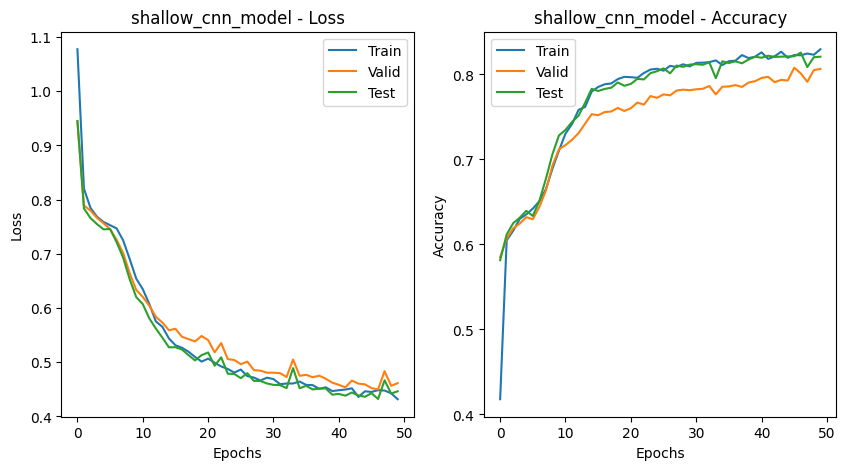

In [27]:
from Shallow_CNN import shallowCNN

batch_size = 64
train_samples = 20000

train_loader, valid_loader, test_loader = create_data_loaders(train_dirs, valid_dirs, test_dirs, 
                                                              batch_size, train_samples)

shallow_cnn_model = shallowCNN()

shallow_cnn_lr = 0.00001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(shallow_cnn_model.parameters(), shallow_cnn_lr)

train_model(shallow_cnn_model, train_loader, valid_loader, test_loader, 50, optimizer,
            criterion, 'shallow_cnn_model', train_samples, shallow_cnn_lr, batch_size, 50)

### VGG16

In [57]:
from VGG16 import VGG16
batch_size = 64
train_samples = 10000

vgg_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))  # VGG models require 224x224 images
])

train_loader, valid_loader, test_loader = create_data_loaders(train_dirs, valid_dirs, test_dirs, 
                                                              batch_size, train_samples, vgg_transform)

vgg_model = VGG16()



vgg_lr = 0.0001
criterion = nn.CrossEntropyLoss()
vgg_optimizer = optim.Adam(vgg_model.parameters(), lr=vgg_lr)

train_model(vgg_model, train_loader, valid_loader, test_loader, epochs=50, optimizer=vgg_optimizer,
            criterion=criterion, title='VGG16', train_samples=train_samples, learning_rate=vgg_lr, batch_size=batch_size, patience=50)


Epoch: 0/50, Train Loss: 0.6073, Train Acc: 0.7541, Valid Loss: 0.5134, Valid Acc: 0.7810, Test Loss: 0.4709, Test Acc: 0.8053


Epoch: 1/50, Train Loss: 0.4961, Train Acc: 0.7957, Valid Loss: 0.4858, Valid Acc: 0.7932, Test Loss: 0.4425, Test Acc: 0.8166


Epoch: 2/50, Train Loss: 0.4771, Train Acc: 0.8018, Valid Loss: 0.4791, Valid Acc: 0.7968, Test Loss: 0.4295, Test Acc: 0.8209


Epoch: 3/50, Train Loss: 0.4832, Train Acc: 0.7990, Valid Loss: 0.4789, Valid Acc: 0.7913, Test Loss: 0.4392, Test Acc: 0.8166


Epoch: 4/50, Train Loss: 0.4623, Train Acc: 0.8122, Valid Loss: 0.4607, Valid Acc: 0.8016, Test Loss: 0.4228, Test Acc: 0.8236


Epoch: 5/50, Train Loss: 0.4634, Train Acc: 0.8111, Valid Loss: 0.4603, Valid Acc: 0.8090, Test Loss: 0.4133, Test Acc: 0.8314


Epoch: 6/50, Train Loss: 0.4683, Train Acc: 0.8044, Valid Loss: 0.4486, Valid Acc: 0.8122, Test Loss: 0.4087, Test Acc: 0.8335


Epoch: 7/50, Train Loss: 0.4510, Train Acc: 0.8148, Valid Loss: 0.4385, Valid Acc: 0.8191, Test Loss: 0.4017, Test Acc: 0.8406


Batches:  53%|█████▎    | 100/187 [00:30<00:25,  3.39it/s]

### InceptionV3

In [40]:
from Inception_v3 import Inceptionv3

batch_size = 128
# train_samples = 100000 # total number of samples in the train set
train_samples = 10000

inception_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((299, 299))
    
])

train_loader, valid_loader, test_loader = create_data_loaders(train_dirs, valid_dirs, test_dirs, 
                                                              batch_size, train_samples,inception_transform)

inceptionV3_model = Inceptionv3()

inception_lr = 0.0001
criterion = nn.CrossEntropyLoss()
inception_optimizer = optim.Adam(filter(lambda p: p.requires_grad, inceptionV3_model.parameters()),inception_lr)

train_model(inceptionV3_model,train_loader,valid_loader,test_loader,50,inception_optimizer,
            criterion,'InceptionV3', train_samples,inception_lr, batch_size, 50)

c:\Users\dgolden\OneDrive - National University of Ireland, Galway\Masters\Semester 2\CT5135 Research Topics in AI\Assignment_2\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dgolden\OneDrive - National University of Ireland, Galway\Masters\Semester 2\CT5135 Research Topics in AI\Assignment_2\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0/50, Train Loss: 0.8038, Train Acc: 0.6786, Valid Loss: 0.6185, Valid Acc: 0.7386, Test Loss: 0.5605, Test Acc: 0.7658


Epoch: 1/50, Train Loss: 0.5175, Train Acc: 0.7921, Valid Loss: 0.5288, Valid Acc: 0.7781, Test Loss: 0.4736, Test Acc: 0.8075


Epoch: 2/50, Train Loss: 0.4904, Train Acc: 0.7988, Valid Loss: 0.4631, Valid Acc: 0.8073, Test Loss: 0.4278, Test Acc: 0.8270


Epoch: 3/50, Train Loss: 0.4817, Train Acc: 0.8001, Valid Loss: 0.4508, Valid Acc: 0.8142, Test Loss: 0.3992, Test Acc: 0.8398


Epoch: 4/50, Train Loss: 0.4605, Train Acc: 0.8152, Valid Loss: 0.4392, Valid Acc: 0.8195, Test Loss: 0.3923, Test Acc: 0.8456


Epoch: 5/50, Train Loss: 0.4577, Train Acc: 0.8178, Valid Loss: 0.4374, Valid Acc: 0.8212, Test Loss: 0.3853, Test Acc: 0.8467


Epoch: 6/50, Train Loss: 0.4665, Train Acc: 0.8094, Valid Loss: 0.4279, Valid Acc: 0.8265, Test Loss: 0.3807, Test Acc: 0.8503


Epoch: 7/50, Train Loss: 0.4512, Train Acc: 0.8192, Valid Loss: 0.4330, Valid Acc: 0.8220, Test Loss: 0.3793, Test Acc: 0.8492


Epoch: 8/50, Train Loss: 0.4454, Train Acc: 0.8219, Valid Loss: 0.4430, Valid Acc: 0.8214, Test Loss: 0.3794, Test Acc: 0.8459


Epoch: 9/50, Train Loss: 0.4610, Train Acc: 0.8157, Valid Loss: 0.4295, Valid Acc: 0.8255, Test Loss: 0.3728, Test Acc: 0.8505


Epoch: 10/50, Train Loss: 0.4646, Train Acc: 0.8159, Valid Loss: 0.4361, Valid Acc: 0.8238, Test Loss: 0.3804, Test Acc: 0.8487


Epoch: 11/50, Train Loss: 0.4442, Train Acc: 0.8242, Valid Loss: 0.4547, Valid Acc: 0.8157, Test Loss: 0.3849, Test Acc: 0.8458


Epoch: 12/50, Train Loss: 0.4550, Train Acc: 0.8200, Valid Loss: 0.4198, Valid Acc: 0.8277, Test Loss: 0.3670, Test Acc: 0.8525


Epoch: 13/50, Train Loss: 0.4512, Train Acc: 0.8219, Valid Loss: 0.4429, Valid Acc: 0.8199, Test Loss: 0.3797, Test Acc: 0.8480


Epoch: 14/50, Train Loss: 0.4605, Train Acc: 0.8130, Valid Loss: 0.4235, Valid Acc: 0.8278, Test Loss: 0.3696, Test Acc: 0.8529


Epoch: 15/50, Train Loss: 0.4336, Train Acc: 0.8242, Valid Loss: 0.4110, Valid Acc: 0.8313, Test Loss: 0.3692, Test Acc: 0.8555


Epoch: 16/50, Train Loss: 0.4362, Train Acc: 0.8222, Valid Loss: 0.4076, Valid Acc: 0.8339, Test Loss: 0.3585, Test Acc: 0.8580


Epoch: 17/50, Train Loss: 0.4456, Train Acc: 0.8174, Valid Loss: 0.4126, Valid Acc: 0.8304, Test Loss: 0.3567, Test Acc: 0.8592


Epoch: 18/50, Train Loss: 0.4327, Train Acc: 0.8240, Valid Loss: 0.4465, Valid Acc: 0.8167, Test Loss: 0.3806, Test Acc: 0.8455


Epoch: 19/50, Train Loss: 0.4223, Train Acc: 0.8289, Valid Loss: 0.4179, Valid Acc: 0.8306, Test Loss: 0.3599, Test Acc: 0.8557


Epoch: 20/50, Train Loss: 0.4385, Train Acc: 0.8223, Valid Loss: 0.3989, Valid Acc: 0.8363, Test Loss: 0.3503, Test Acc: 0.8660


KeyboardInterrupt: 

### ResNet18 

Epoch: 0/50, Train Loss: 0.6473, Train Acc: 0.7697, Valid Loss: 0.4192, Valid Acc: 0.8415, Test Loss: 0.3863, Test Acc: 0.8660


Epoch: 1/50, Train Loss: 0.3139, Train Acc: 0.8848, Valid Loss: 0.3015, Valid Acc: 0.8813, Test Loss: 0.2675, Test Acc: 0.9017


Epoch: 2/50, Train Loss: 0.2469, Train Acc: 0.9083, Valid Loss: 0.2709, Valid Acc: 0.8933, Test Loss: 0.2319, Test Acc: 0.9147


Epoch: 3/50, Train Loss: 0.2191, Train Acc: 0.9193, Valid Loss: 0.2417, Valid Acc: 0.9033, Test Loss: 0.2111, Test Acc: 0.9232


Epoch: 4/50, Train Loss: 0.2013, Train Acc: 0.9237, Valid Loss: 0.2254, Valid Acc: 0.9102, Test Loss: 0.1949, Test Acc: 0.9300


Epoch: 5/50, Train Loss: 0.1859, Train Acc: 0.9286, Valid Loss: 0.2057, Valid Acc: 0.9195, Test Loss: 0.1846, Test Acc: 0.9341


Epoch: 6/50, Train Loss: 0.1709, Train Acc: 0.9370, Valid Loss: 0.2011, Valid Acc: 0.9200, Test Loss: 0.1734, Test Acc: 0.9373


Epoch: 7/50, Train Loss: 0.1623, Train Acc: 0.9401, Valid Loss: 0.1879, Valid Acc: 0.9262, Test Loss: 0.1655, Test Acc: 0.9385


Epoch: 8/50, Train Loss: 0.1529, Train Acc: 0.9425, Valid Loss: 0.1826, Valid Acc: 0.9294, Test Loss: 0.1601, Test Acc: 0.9406


Epoch: 9/50, Train Loss: 0.1432, Train Acc: 0.9469, Valid Loss: 0.1763, Valid Acc: 0.9326, Test Loss: 0.1514, Test Acc: 0.9452


Epoch: 10/50, Train Loss: 0.1337, Train Acc: 0.9516, Valid Loss: 0.1653, Valid Acc: 0.9358, Test Loss: 0.1498, Test Acc: 0.9443


Epoch: 11/50, Train Loss: 0.1295, Train Acc: 0.9523, Valid Loss: 0.1602, Valid Acc: 0.9394, Test Loss: 0.1439, Test Acc: 0.9454


Epoch: 12/50, Train Loss: 0.1207, Train Acc: 0.9548, Valid Loss: 0.1591, Valid Acc: 0.9396, Test Loss: 0.1411, Test Acc: 0.9481


Epoch: 13/50, Train Loss: 0.1157, Train Acc: 0.9574, Valid Loss: 0.1515, Valid Acc: 0.9427, Test Loss: 0.1374, Test Acc: 0.9475


Epoch: 14/50, Train Loss: 0.1103, Train Acc: 0.9594, Valid Loss: 0.1471, Valid Acc: 0.9431, Test Loss: 0.1352, Test Acc: 0.9503


Epoch: 15/50, Train Loss: 0.1041, Train Acc: 0.9630, Valid Loss: 0.1438, Valid Acc: 0.9457, Test Loss: 0.1331, Test Acc: 0.9502


Epoch: 16/50, Train Loss: 0.1005, Train Acc: 0.9651, Valid Loss: 0.1481, Valid Acc: 0.9450, Test Loss: 0.1334, Test Acc: 0.9505


Epoch: 17/50, Train Loss: 0.0977, Train Acc: 0.9656, Valid Loss: 0.1432, Valid Acc: 0.9468, Test Loss: 0.1304, Test Acc: 0.9525


Epoch: 18/50, Train Loss: 0.0921, Train Acc: 0.9675, Valid Loss: 0.1353, Valid Acc: 0.9496, Test Loss: 0.1261, Test Acc: 0.9552


Epoch: 19/50, Train Loss: 0.0864, Train Acc: 0.9673, Valid Loss: 0.1375, Valid Acc: 0.9485, Test Loss: 0.1310, Test Acc: 0.9521


Epoch: 20/50, Train Loss: 0.0858, Train Acc: 0.9698, Valid Loss: 0.1392, Valid Acc: 0.9483, Test Loss: 0.1280, Test Acc: 0.9531


Epoch: 21/50, Train Loss: 0.0810, Train Acc: 0.9705, Valid Loss: 0.1337, Valid Acc: 0.9511, Test Loss: 0.1288, Test Acc: 0.9525


Epoch: 22/50, Train Loss: 0.0790, Train Acc: 0.9736, Valid Loss: 0.1304, Valid Acc: 0.9515, Test Loss: 0.1231, Test Acc: 0.9552


Epoch: 23/50, Train Loss: 0.0746, Train Acc: 0.9740, Valid Loss: 0.1350, Valid Acc: 0.9514, Test Loss: 0.1251, Test Acc: 0.9562


Epoch: 24/50, Train Loss: 0.0702, Train Acc: 0.9755, Valid Loss: 0.1249, Valid Acc: 0.9545, Test Loss: 0.1211, Test Acc: 0.9566


Epoch: 25/50, Train Loss: 0.0693, Train Acc: 0.9760, Valid Loss: 0.1291, Valid Acc: 0.9539, Test Loss: 0.1282, Test Acc: 0.9549


Epoch: 26/50, Train Loss: 0.0692, Train Acc: 0.9755, Valid Loss: 0.1238, Valid Acc: 0.9558, Test Loss: 0.1206, Test Acc: 0.9594


Epoch: 27/50, Train Loss: 0.0628, Train Acc: 0.9794, Valid Loss: 0.1248, Valid Acc: 0.9544, Test Loss: 0.1224, Test Acc: 0.9577


Epoch: 28/50, Train Loss: 0.0632, Train Acc: 0.9774, Valid Loss: 0.1252, Valid Acc: 0.9549, Test Loss: 0.1213, Test Acc: 0.9573


Epoch: 29/50, Train Loss: 0.0554, Train Acc: 0.9808, Valid Loss: 0.1256, Valid Acc: 0.9553, Test Loss: 0.1171, Test Acc: 0.9593


Epoch: 30/50, Train Loss: 0.0517, Train Acc: 0.9829, Valid Loss: 0.1253, Valid Acc: 0.9560, Test Loss: 0.1199, Test Acc: 0.9594


Epoch: 31/50, Train Loss: 0.0511, Train Acc: 0.9829, Valid Loss: 0.1257, Valid Acc: 0.9560, Test Loss: 0.1161, Test Acc: 0.9588


Epoch: 32/50, Train Loss: 0.0496, Train Acc: 0.9832, Valid Loss: 0.1312, Valid Acc: 0.9541, Test Loss: 0.1213, Test Acc: 0.9597


Epoch: 33/50, Train Loss: 0.0449, Train Acc: 0.9850, Valid Loss: 0.1288, Valid Acc: 0.9561, Test Loss: 0.1224, Test Acc: 0.9581


Epoch: 34/50, Train Loss: 0.0490, Train Acc: 0.9837, Valid Loss: 0.1276, Valid Acc: 0.9557, Test Loss: 0.1178, Test Acc: 0.9594


Epoch: 35/50, Train Loss: 0.0463, Train Acc: 0.9845, Valid Loss: 0.1271, Valid Acc: 0.9557, Test Loss: 0.1208, Test Acc: 0.9587


Epoch: 36/50, Train Loss: 0.0448, Train Acc: 0.9853, Valid Loss: 0.1298, Valid Acc: 0.9557, Test Loss: 0.1265, Test Acc: 0.9582


Epoch: 37/50, Train Loss: 0.0396, Train Acc: 0.9862, Valid Loss: 0.1193, Valid Acc: 0.9588, Test Loss: 0.1173, Test Acc: 0.9613


Epoch: 38/50, Train Loss: 0.0390, Train Acc: 0.9873, Valid Loss: 0.1245, Valid Acc: 0.9586, Test Loss: 0.1253, Test Acc: 0.9591


Epoch: 39/50, Train Loss: 0.0395, Train Acc: 0.9860, Valid Loss: 0.1269, Valid Acc: 0.9581, Test Loss: 0.1249, Test Acc: 0.9585


Epoch: 40/50, Train Loss: 0.0361, Train Acc: 0.9879, Valid Loss: 0.1262, Valid Acc: 0.9573, Test Loss: 0.1238, Test Acc: 0.9606


Epoch: 41/50, Train Loss: 0.0337, Train Acc: 0.9889, Valid Loss: 0.1256, Valid Acc: 0.9582, Test Loss: 0.1256, Test Acc: 0.9601


Epoch: 42/50, Train Loss: 0.0337, Train Acc: 0.9887, Valid Loss: 0.1314, Valid Acc: 0.9563, Test Loss: 0.1275, Test Acc: 0.9595


Epoch: 43/50, Train Loss: 0.0341, Train Acc: 0.9891, Valid Loss: 0.1397, Valid Acc: 0.9556, Test Loss: 0.1370, Test Acc: 0.9566


Epoch: 44/50, Train Loss: 0.0369, Train Acc: 0.9870, Valid Loss: 0.1266, Valid Acc: 0.9582, Test Loss: 0.1219, Test Acc: 0.9624


Epoch: 45/50, Train Loss: 0.0288, Train Acc: 0.9896, Valid Loss: 0.1323, Valid Acc: 0.9583, Test Loss: 0.1250, Test Acc: 0.9609


Epoch: 46/50, Train Loss: 0.0291, Train Acc: 0.9907, Valid Loss: 0.1365, Valid Acc: 0.9569, Test Loss: 0.1322, Test Acc: 0.9599


Epoch: 47/50, Train Loss: 0.0282, Train Acc: 0.9909, Valid Loss: 0.1326, Valid Acc: 0.9585, Test Loss: 0.1274, Test Acc: 0.9616


Epoch: 48/50, Train Loss: 0.0237, Train Acc: 0.9923, Valid Loss: 0.1338, Valid Acc: 0.9593, Test Loss: 0.1324, Test Acc: 0.9601


Epoch: 49/50, Train Loss: 0.0256, Train Acc: 0.9929, Valid Loss: 0.1325, Valid Acc: 0.9600, Test Loss: 0.1310, Test Acc: 0.9602


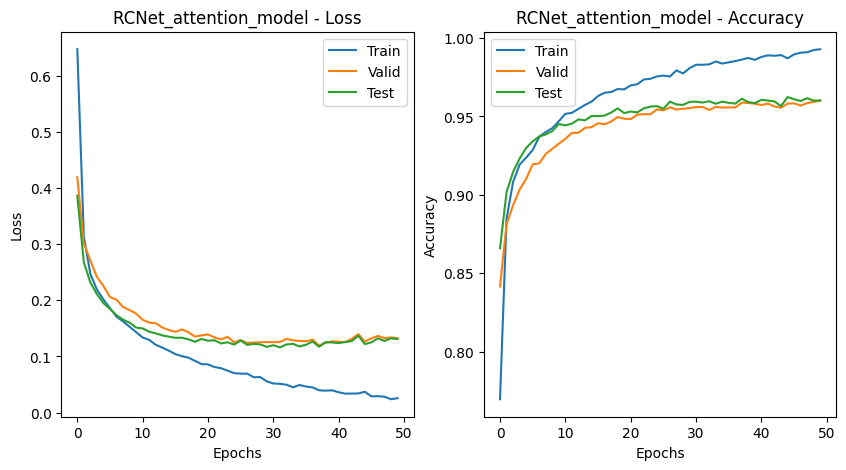

In [33]:
from ResNet18 import ResNet18  # Import your custom ResNet18 class

batch_size = 128
train_samples = 20000  
# # Assuming you have defined the transformation for ResNet model
resnet_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])

train_loader, valid_loader, test_loader = create_data_loaders(train_dirs, valid_dirs, test_dirs, 
                                                              batch_size, train_samples)

resnet_model = ResNet18(num_classes=3)  # Instantiate your custom ResNet18 model

resnet_lr = 0.00001
criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=resnet_lr)

train_model(resnet_model, train_loader, valid_loader, test_loader, epochs=50, optimizer=resnet_optimizer,
            criterion=criterion, title='ResNet18', train_samples=train_samples,
            learning_rate=resnet_lr, batch_size=batch_size, patience=50)

### RCNet

Epoch: 0/50, Train Loss: 0.8175, Train Acc: 0.6085, Valid Loss: 1.2570, Valid Acc: 0.4796, Test Loss: 1.1474, Test Acc: 0.4931


Epoch: 1/50, Train Loss: 0.5117, Train Acc: 0.7962, Valid Loss: 0.5644, Valid Acc: 0.7424, Test Loss: 0.5612, Test Acc: 0.7434


Epoch: 2/50, Train Loss: 0.4569, Train Acc: 0.8230, Valid Loss: 0.4838, Valid Acc: 0.7974, Test Loss: 0.4820, Test Acc: 0.8105


Epoch: 3/50, Train Loss: 0.4274, Train Acc: 0.8364, Valid Loss: 0.6619, Valid Acc: 0.6930, Test Loss: 0.6697, Test Acc: 0.6906


Epoch: 4/50, Train Loss: 0.4150, Train Acc: 0.8399, Valid Loss: 0.7369, Valid Acc: 0.7235, Test Loss: 0.6813, Test Acc: 0.7378


Epoch: 5/50, Train Loss: 0.3856, Train Acc: 0.8508, Valid Loss: 0.5644, Valid Acc: 0.7430, Test Loss: 0.5493, Test Acc: 0.7439


Epoch: 6/50, Train Loss: 0.3604, Train Acc: 0.8625, Valid Loss: 1.0256, Valid Acc: 0.6579, Test Loss: 0.9309, Test Acc: 0.6676


Epoch: 7/50, Train Loss: 0.3516, Train Acc: 0.8643, Valid Loss: 0.6886, Valid Acc: 0.7161, Test Loss: 0.6447, Test Acc: 0.7426


Epoch: 8/50, Train Loss: 0.3406, Train Acc: 0.8699, Valid Loss: 0.4060, Valid Acc: 0.8238, Test Loss: 0.4013, Test Acc: 0.8267


Epoch: 9/50, Train Loss: 0.3182, Train Acc: 0.8799, Valid Loss: 0.3839, Valid Acc: 0.8520, Test Loss: 0.3421, Test Acc: 0.8789


Epoch: 10/50, Train Loss: 0.3076, Train Acc: 0.8843, Valid Loss: 0.3421, Valid Acc: 0.8594, Test Loss: 0.2963, Test Acc: 0.8875


Epoch: 11/50, Train Loss: 0.3036, Train Acc: 0.8845, Valid Loss: 0.3313, Valid Acc: 0.8668, Test Loss: 0.3105, Test Acc: 0.8841


Epoch: 12/50, Train Loss: 0.2828, Train Acc: 0.8910, Valid Loss: 0.3930, Valid Acc: 0.8335, Test Loss: 0.3345, Test Acc: 0.8697


Epoch: 13/50, Train Loss: 0.2787, Train Acc: 0.8930, Valid Loss: 0.3242, Valid Acc: 0.8714, Test Loss: 0.3016, Test Acc: 0.8875


Epoch: 14/50, Train Loss: 0.2738, Train Acc: 0.8950, Valid Loss: 0.3856, Valid Acc: 0.8462, Test Loss: 0.3649, Test Acc: 0.8566


Epoch: 15/50, Train Loss: 0.2790, Train Acc: 0.8962, Valid Loss: 0.5525, Valid Acc: 0.7594, Test Loss: 0.5037, Test Acc: 0.7842


Epoch: 16/50, Train Loss: 0.2649, Train Acc: 0.9016, Valid Loss: 0.3594, Valid Acc: 0.8569, Test Loss: 0.3390, Test Acc: 0.8708


Epoch: 17/50, Train Loss: 0.2604, Train Acc: 0.9022, Valid Loss: 0.4351, Valid Acc: 0.8251, Test Loss: 0.4075, Test Acc: 0.8445


Epoch: 18/50, Train Loss: 0.2480, Train Acc: 0.9053, Valid Loss: 0.2825, Valid Acc: 0.8894, Test Loss: 0.2720, Test Acc: 0.8985


Epoch: 19/50, Train Loss: 0.2397, Train Acc: 0.9101, Valid Loss: 0.3562, Valid Acc: 0.8482, Test Loss: 0.3582, Test Acc: 0.8490


Epoch: 20/50, Train Loss: 0.2447, Train Acc: 0.9082, Valid Loss: 0.3194, Valid Acc: 0.8714, Test Loss: 0.2759, Test Acc: 0.8956


Epoch: 21/50, Train Loss: 0.2403, Train Acc: 0.9100, Valid Loss: 0.3045, Valid Acc: 0.8838, Test Loss: 0.2753, Test Acc: 0.8989


Epoch: 22/50, Train Loss: 0.2400, Train Acc: 0.9088, Valid Loss: 0.4137, Valid Acc: 0.8470, Test Loss: 0.3361, Test Acc: 0.8764


Epoch: 23/50, Train Loss: 0.2347, Train Acc: 0.9120, Valid Loss: 0.5384, Valid Acc: 0.7937, Test Loss: 0.5294, Test Acc: 0.8049


Epoch: 24/50, Train Loss: 0.2271, Train Acc: 0.9157, Valid Loss: 0.3408, Valid Acc: 0.8722, Test Loss: 0.2818, Test Acc: 0.8962


Epoch: 25/50, Train Loss: 0.2220, Train Acc: 0.9186, Valid Loss: 0.2793, Valid Acc: 0.8876, Test Loss: 0.2693, Test Acc: 0.8931


Epoch: 26/50, Train Loss: 0.2265, Train Acc: 0.9163, Valid Loss: 0.3859, Valid Acc: 0.8483, Test Loss: 0.3930, Test Acc: 0.8441


Epoch: 27/50, Train Loss: 0.2257, Train Acc: 0.9168, Valid Loss: 0.3114, Valid Acc: 0.8833, Test Loss: 0.3018, Test Acc: 0.8867


Epoch: 28/50, Train Loss: 0.2144, Train Acc: 0.9196, Valid Loss: 0.3156, Valid Acc: 0.8749, Test Loss: 0.2752, Test Acc: 0.8964


Epoch: 29/50, Train Loss: 0.2188, Train Acc: 0.9190, Valid Loss: 0.2551, Valid Acc: 0.9022, Test Loss: 0.2211, Test Acc: 0.9205


Epoch: 30/50, Train Loss: 0.2123, Train Acc: 0.9216, Valid Loss: 0.3162, Valid Acc: 0.8741, Test Loss: 0.2803, Test Acc: 0.8949


Epoch: 31/50, Train Loss: 0.2132, Train Acc: 0.9184, Valid Loss: 0.2852, Valid Acc: 0.8886, Test Loss: 0.2560, Test Acc: 0.9037


Epoch: 32/50, Train Loss: 0.2104, Train Acc: 0.9217, Valid Loss: 0.3766, Valid Acc: 0.8554, Test Loss: 0.3054, Test Acc: 0.8804


Epoch: 33/50, Train Loss: 0.2108, Train Acc: 0.9222, Valid Loss: 0.2289, Valid Acc: 0.9127, Test Loss: 0.2166, Test Acc: 0.9195


Epoch: 34/50, Train Loss: 0.1978, Train Acc: 0.9269, Valid Loss: 0.3384, Valid Acc: 0.8603, Test Loss: 0.3306, Test Acc: 0.8613


Epoch: 35/50, Train Loss: 0.1974, Train Acc: 0.9249, Valid Loss: 0.2386, Valid Acc: 0.9069, Test Loss: 0.2168, Test Acc: 0.9194


Epoch: 36/50, Train Loss: 0.1948, Train Acc: 0.9282, Valid Loss: 0.3263, Valid Acc: 0.8742, Test Loss: 0.2940, Test Acc: 0.8896


Epoch: 37/50, Train Loss: 0.1855, Train Acc: 0.9323, Valid Loss: 0.3068, Valid Acc: 0.8869, Test Loss: 0.2326, Test Acc: 0.9162


Epoch: 38/50, Train Loss: 0.1981, Train Acc: 0.9258, Valid Loss: 0.3242, Valid Acc: 0.8781, Test Loss: 0.3115, Test Acc: 0.8838


Epoch: 39/50, Train Loss: 0.2020, Train Acc: 0.9233, Valid Loss: 0.3603, Valid Acc: 0.8570, Test Loss: 0.2826, Test Acc: 0.8883


Epoch: 40/50, Train Loss: 0.1923, Train Acc: 0.9280, Valid Loss: 0.2660, Valid Acc: 0.8952, Test Loss: 0.2336, Test Acc: 0.9109


Epoch: 41/50, Train Loss: 0.1836, Train Acc: 0.9315, Valid Loss: 0.2509, Valid Acc: 0.9100, Test Loss: 0.1961, Test Acc: 0.9289


Epoch: 42/50, Train Loss: 0.1819, Train Acc: 0.9322, Valid Loss: 0.2233, Valid Acc: 0.9166, Test Loss: 0.2035, Test Acc: 0.9284


Epoch: 43/50, Train Loss: 0.1817, Train Acc: 0.9308, Valid Loss: 0.2577, Valid Acc: 0.9000, Test Loss: 0.2045, Test Acc: 0.9237


Epoch: 44/50, Train Loss: 0.1789, Train Acc: 0.9331, Valid Loss: 0.4622, Valid Acc: 0.8263, Test Loss: 0.3832, Test Acc: 0.8471


Epoch: 45/50, Train Loss: 0.1785, Train Acc: 0.9337, Valid Loss: 0.2066, Valid Acc: 0.9226, Test Loss: 0.1939, Test Acc: 0.9326


Epoch: 46/50, Train Loss: 0.1788, Train Acc: 0.9315, Valid Loss: 0.2160, Valid Acc: 0.9175, Test Loss: 0.2007, Test Acc: 0.9268


Epoch: 47/50, Train Loss: 0.1712, Train Acc: 0.9351, Valid Loss: 0.2050, Valid Acc: 0.9211, Test Loss: 0.1761, Test Acc: 0.9342


Epoch: 48/50, Train Loss: 0.1799, Train Acc: 0.9336, Valid Loss: 0.2138, Valid Acc: 0.9170, Test Loss: 0.1764, Test Acc: 0.9341


Epoch: 49/50, Train Loss: 0.1786, Train Acc: 0.9360, Valid Loss: 0.2200, Valid Acc: 0.9140, Test Loss: 0.1823, Test Acc: 0.9338


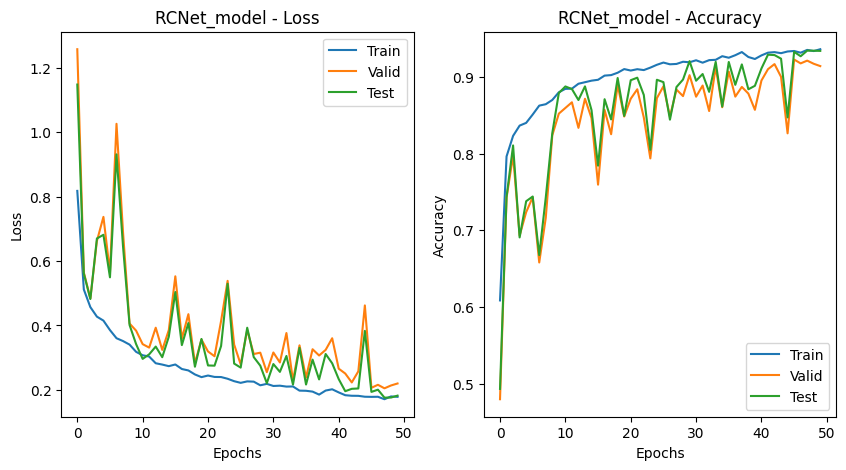

In [35]:
from RCNet import RCNet


batch_size = 128
# train_samples = 100000
train_samples = 20000


train_loader, valid_loader, test_loader = create_data_loaders(train_dirs, valid_dirs, test_dirs, 
                                                              batch_size, train_samples)

RCNet_model = RCNet()

RCNet_lr = 0.0001
criterion = nn.CrossEntropyLoss()
RCNet_optimizer = optim.Adam(RCNet_model.parameters(),RCNet_lr)

train_model(RCNet_model,train_loader,valid_loader,test_loader,50,RCNet_optimizer,
            criterion,'RCNet_model', train_samples, RCNet_lr, batch_size, 50)

### RCNet with CBAM attention

Epoch: 0/50, Train Loss: 0.1146, Train Acc: 0.9595, Valid Loss: 0.1962, Valid Acc: 0.9350, Test Loss: 0.1661, Test Acc: 0.9462


Epoch: 1/50, Train Loss: 0.1090, Train Acc: 0.9611, Valid Loss: 0.2084, Valid Acc: 0.9258, Test Loss: 0.1958, Test Acc: 0.9328


Epoch: 2/50, Train Loss: 0.1135, Train Acc: 0.9598, Valid Loss: 0.1640, Valid Acc: 0.9394, Test Loss: 0.1260, Test Acc: 0.9555


Epoch: 3/50, Train Loss: 0.1085, Train Acc: 0.9611, Valid Loss: 0.1650, Valid Acc: 0.9426, Test Loss: 0.1331, Test Acc: 0.9549


Epoch: 4/50, Train Loss: 0.1105, Train Acc: 0.9610, Valid Loss: 0.1956, Valid Acc: 0.9321, Test Loss: 0.1582, Test Acc: 0.9478


Epoch: 5/50, Train Loss: 0.1100, Train Acc: 0.9598, Valid Loss: 0.1739, Valid Acc: 0.9347, Test Loss: 0.1364, Test Acc: 0.9523


Epoch: 6/50, Train Loss: 0.1121, Train Acc: 0.9600, Valid Loss: 0.1647, Valid Acc: 0.9428, Test Loss: 0.1454, Test Acc: 0.9489


Epoch: 7/50, Train Loss: 0.1124, Train Acc: 0.9591, Valid Loss: 0.1445, Valid Acc: 0.9493, Test Loss: 0.1242, Test Acc: 0.9571


Epoch: 8/50, Train Loss: 0.1055, Train Acc: 0.9626, Valid Loss: 0.1583, Valid Acc: 0.9431, Test Loss: 0.1322, Test Acc: 0.9531


Epoch: 9/50, Train Loss: 0.1012, Train Acc: 0.9628, Valid Loss: 0.1582, Valid Acc: 0.9429, Test Loss: 0.1209, Test Acc: 0.9607


Epoch: 10/50, Train Loss: 0.1052, Train Acc: 0.9623, Valid Loss: 0.1828, Valid Acc: 0.9358, Test Loss: 0.1672, Test Acc: 0.9422


Epoch: 11/50, Train Loss: 0.1018, Train Acc: 0.9641, Valid Loss: 0.1942, Valid Acc: 0.9329, Test Loss: 0.1646, Test Acc: 0.9472


Epoch: 12/50, Train Loss: 0.1059, Train Acc: 0.9616, Valid Loss: 0.2393, Valid Acc: 0.9212, Test Loss: 0.2244, Test Acc: 0.9273


Epoch: 13/50, Train Loss: 0.1094, Train Acc: 0.9607, Valid Loss: 0.1318, Valid Acc: 0.9520, Test Loss: 0.1167, Test Acc: 0.9601


Epoch: 14/50, Train Loss: 0.0989, Train Acc: 0.9634, Valid Loss: 0.2023, Valid Acc: 0.9290, Test Loss: 0.1646, Test Acc: 0.9458


Epoch: 15/50, Train Loss: 0.1030, Train Acc: 0.9638, Valid Loss: 0.1626, Valid Acc: 0.9399, Test Loss: 0.1241, Test Acc: 0.9567


Epoch: 16/50, Train Loss: 0.0997, Train Acc: 0.9637, Valid Loss: 0.1417, Valid Acc: 0.9496, Test Loss: 0.1145, Test Acc: 0.9609


Epoch: 17/50, Train Loss: 0.0991, Train Acc: 0.9642, Valid Loss: 0.2800, Valid Acc: 0.9074, Test Loss: 0.2630, Test Acc: 0.9153


Epoch: 18/50, Train Loss: 0.1015, Train Acc: 0.9628, Valid Loss: 0.1473, Valid Acc: 0.9466, Test Loss: 0.1203, Test Acc: 0.9588


Epoch: 19/50, Train Loss: 0.0998, Train Acc: 0.9629, Valid Loss: 0.2119, Valid Acc: 0.9290, Test Loss: 0.1976, Test Acc: 0.9352


Epoch: 20/50, Train Loss: 0.0981, Train Acc: 0.9647, Valid Loss: 0.2101, Valid Acc: 0.9310, Test Loss: 0.1909, Test Acc: 0.9387


Epoch: 21/50, Train Loss: 0.0969, Train Acc: 0.9654, Valid Loss: 0.1687, Valid Acc: 0.9426, Test Loss: 0.1470, Test Acc: 0.9508


Epoch: 22/50, Train Loss: 0.0953, Train Acc: 0.9651, Valid Loss: 0.2172, Valid Acc: 0.9289, Test Loss: 0.1950, Test Acc: 0.9353


Epoch: 23/50, Train Loss: 0.0957, Train Acc: 0.9652, Valid Loss: 0.1486, Valid Acc: 0.9498, Test Loss: 0.1275, Test Acc: 0.9584


Epoch: 24/50, Train Loss: 0.0964, Train Acc: 0.9646, Valid Loss: 0.1792, Valid Acc: 0.9398, Test Loss: 0.1595, Test Acc: 0.9482


Epoch: 25/50, Train Loss: 0.0956, Train Acc: 0.9645, Valid Loss: 0.1563, Valid Acc: 0.9467, Test Loss: 0.1393, Test Acc: 0.9531


Epoch: 26/50, Train Loss: 0.0931, Train Acc: 0.9665, Valid Loss: 0.1486, Valid Acc: 0.9473, Test Loss: 0.1195, Test Acc: 0.9597


Epoch: 27/50, Train Loss: 0.0975, Train Acc: 0.9651, Valid Loss: 0.1940, Valid Acc: 0.9368, Test Loss: 0.1737, Test Acc: 0.9427


Epoch: 28/50, Train Loss: 0.0984, Train Acc: 0.9647, Valid Loss: 0.1481, Valid Acc: 0.9493, Test Loss: 0.1311, Test Acc: 0.9569


Epoch: 29/50, Train Loss: 0.0965, Train Acc: 0.9649, Valid Loss: 0.1465, Valid Acc: 0.9494, Test Loss: 0.1282, Test Acc: 0.9587


Epoch: 30/50, Train Loss: 0.0912, Train Acc: 0.9677, Valid Loss: 0.1729, Valid Acc: 0.9416, Test Loss: 0.1523, Test Acc: 0.9493


Epoch: 31/50, Train Loss: 0.0892, Train Acc: 0.9686, Valid Loss: 0.2229, Valid Acc: 0.9289, Test Loss: 0.2133, Test Acc: 0.9337


Epoch: 32/50, Train Loss: 0.0915, Train Acc: 0.9678, Valid Loss: 0.2806, Valid Acc: 0.9143, Test Loss: 0.2640, Test Acc: 0.9172


Epoch: 33/50, Train Loss: 0.0914, Train Acc: 0.9676, Valid Loss: 0.1487, Valid Acc: 0.9509, Test Loss: 0.1300, Test Acc: 0.9588


Epoch: 34/50, Train Loss: 0.0896, Train Acc: 0.9678, Valid Loss: 0.1890, Valid Acc: 0.9383, Test Loss: 0.1635, Test Acc: 0.9476


Epoch: 35/50, Train Loss: 0.0897, Train Acc: 0.9672, Valid Loss: 0.2537, Valid Acc: 0.9112, Test Loss: 0.2419, Test Acc: 0.9148


Epoch: 36/50, Train Loss: 0.0886, Train Acc: 0.9675, Valid Loss: 0.1425, Valid Acc: 0.9521, Test Loss: 0.1240, Test Acc: 0.9586


Epoch: 37/50, Train Loss: 0.0925, Train Acc: 0.9676, Valid Loss: 0.1441, Valid Acc: 0.9508, Test Loss: 0.1228, Test Acc: 0.9599


Epoch: 38/50, Train Loss: 0.0849, Train Acc: 0.9696, Valid Loss: 0.2176, Valid Acc: 0.9295, Test Loss: 0.1992, Test Acc: 0.9355


Epoch: 39/50, Train Loss: 0.0897, Train Acc: 0.9688, Valid Loss: 0.1415, Valid Acc: 0.9506, Test Loss: 0.1193, Test Acc: 0.9585


Epoch: 40/50, Train Loss: 0.0880, Train Acc: 0.9687, Valid Loss: 0.1307, Valid Acc: 0.9531, Test Loss: 0.1119, Test Acc: 0.9630


Epoch: 41/50, Train Loss: 0.0886, Train Acc: 0.9677, Valid Loss: 0.1837, Valid Acc: 0.9385, Test Loss: 0.1673, Test Acc: 0.9463


Epoch: 42/50, Train Loss: 0.0881, Train Acc: 0.9675, Valid Loss: 0.1634, Valid Acc: 0.9453, Test Loss: 0.1387, Test Acc: 0.9537


Epoch: 43/50, Train Loss: 0.0874, Train Acc: 0.9687, Valid Loss: 0.1687, Valid Acc: 0.9432, Test Loss: 0.1286, Test Acc: 0.9569


Epoch: 44/50, Train Loss: 0.0863, Train Acc: 0.9697, Valid Loss: 0.1245, Valid Acc: 0.9556, Test Loss: 0.1064, Test Acc: 0.9647


Epoch: 45/50, Train Loss: 0.0856, Train Acc: 0.9689, Valid Loss: 0.1907, Valid Acc: 0.9384, Test Loss: 0.1755, Test Acc: 0.9430


Epoch: 46/50, Train Loss: 0.0847, Train Acc: 0.9697, Valid Loss: 0.1446, Valid Acc: 0.9531, Test Loss: 0.1250, Test Acc: 0.9619


Epoch: 47/50, Train Loss: 0.0864, Train Acc: 0.9690, Valid Loss: 0.1589, Valid Acc: 0.9454, Test Loss: 0.1367, Test Acc: 0.9540


Epoch: 48/50, Train Loss: 0.0882, Train Acc: 0.9683, Valid Loss: 0.1269, Valid Acc: 0.9533, Test Loss: 0.1058, Test Acc: 0.9642


Epoch: 49/50, Train Loss: 0.0831, Train Acc: 0.9712, Valid Loss: 0.1699, Valid Acc: 0.9395, Test Loss: 0.1259, Test Acc: 0.9562


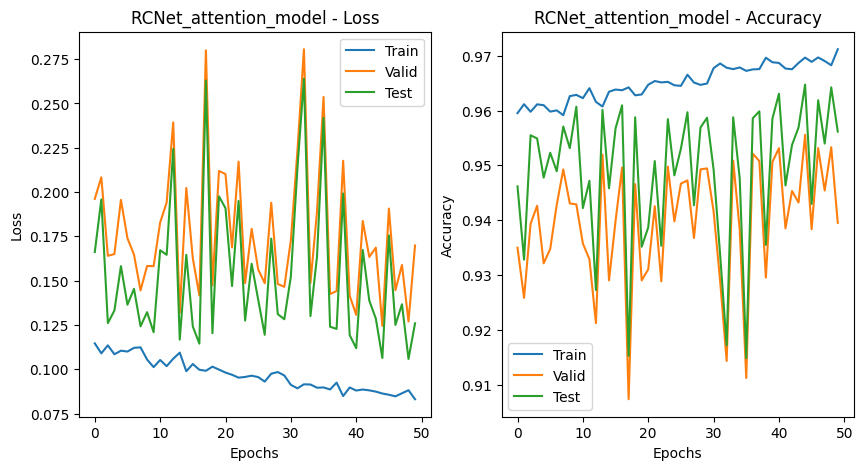

In [39]:
from RCNet_CBAM_Attention import RCNet_attention


batch_size = 128
# train_samples = 100000
train_samples = 40000


train_loader, valid_loader, test_loader = create_data_loaders(train_dirs, valid_dirs, test_dirs, 
                                                              batch_size, train_samples)

RCNet_attention_model = RCNet_attention()
checkpoint = torch.load('models/20240331164717/40.chkpt')

# Load the model state_dict
RCNet_attention_model.load_state_dict(checkpoint)

RCNet_attention_model
RCNet_attention_lr = 0.00005
criterion = nn.CrossEntropyLoss()
RCNet_attention_optimizer = optim.Adam(RCNet_attention_model.parameters(),RCNet_attention_lr)

train_model(RCNet_attention_model,train_loader,valid_loader,test_loader,50,RCNet_attention_optimizer,
            criterion,'RCNet_attention_model', train_samples, RCNet_attention_lr, batch_size, 50)

# Model evaluation

In [55]:
# List of tuples containing models and their names
models_list = [
    (shallow_cnn_model, "shallow_cnn_model"),
    (inceptionV3_model, "inceptionV3_model"),
    (vgg_model, "vgg_model"),
    (resnet_model, "resnet_model"),
    (RCNet_model, "RCNet_model"),
    (RCNet_attention_model, "RCNet_attention_model")
]

In [56]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Iterate through models and print total parameters
for model, name in models_list:
    total_params, trainable_params = count_parameters(model)
    print(f"Model: {name}")
    print("Total parameters: ", total_params)
    print("Trainable parameters: ", trainable_params)
    print()

Model: shallow_cnn_model
Total parameters:  2492835
Trainable parameters:  2492835

Model: inceptionV3_model
Total parameters:  26293451
Trainable parameters:  1181187

Model: vgg_model
Total parameters:  136490307
Trainable parameters:  2229763

Model: resnet_model
Total parameters:  11440707
Trainable parameters:  11440707

Model: RCNet_model
Total parameters:  4829731
Trainable parameters:  4829731

Model: RCNet_attention_model
Total parameters:  4849507
Trainable parameters:  4849507



### Learning and accuracy curves

### Confusion matrices

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def produce_confusion_matrices(model, model_name, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set the model to evaluation mode
    model.eval()

    # Initialize lists to store true labels and predictions
    all_labels = []
    all_preds = []

    with torch.no_grad():
        test_loss = 0
        test_correct = 0
        for images, labels in test_loader:
            # Move data to the appropriate device
            images, labels = images.to(device), labels.to(device)
            labels = labels.to(torch.long)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update test loss
            test_loss += loss.item() * images.size(0)

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)

            # Update accuracy
            test_correct += (predicted == labels).sum().item()

            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate the overall loss and accuracy
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = test_correct / len(test_loader.dataset)

    print(f'Model: {model_name}')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Example usage:
criterion = nn.CrossEntropyLoss()
for model, name in models_list:

    produce_confusion_matrices(model, name, test_loader, criterion)


# Model Visualisation

In [50]:
from torchview import draw_graph
from torchvision.models import resnet18, GoogLeNet, densenet, vit_b_16
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

model_graph = draw_graph(RCNet_attention(), input_size=(1,3,64,96), expand_nested=True)

In [51]:
model_graph.visual_graph


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH